In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
df = pd.read_csv('cleansed_data.csv')
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeGroup
0,619.0,France,Female,42.0,2,0.00,1.0,1,1,101348.88,1,40-50
1,608.0,Spain,Female,41.0,1,83807.86,1.0,0,1,112542.58,0,40-50
2,502.0,France,Female,42.0,8,159660.80,3.0,1,0,113931.57,1,40-50
3,699.0,France,Female,39.0,1,0.00,2.0,0,0,93826.63,0,30-40
4,850.0,Spain,Female,43.0,2,125510.82,1.0,1,1,79084.10,0,40-50


### **Data Preprocessing**

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Exited']), df['Exited'],test_size=0.2,random_state=42)
X_train.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,AgeGroup
9254,686.0,France,Male,32.0,6,0.00,2.0,1,1,179093.26,30-40
1561,632.0,Germany,Male,42.0,4,119624.60,2.0,1,1,195978.86,40-50
1670,559.0,Spain,Male,24.0,3,114739.92,1.0,1,0,85891.02,0-30
6087,561.0,France,Female,27.0,9,135637.00,1.0,1,0,153080.40,0-30
6669,517.0,France,Male,56.0,9,142147.32,1.0,0,0,39488.04,50-60


In [4]:
numerical_columns = [0, 3, 4, 5, 6, 7, 8, 9]
nominal_columns = [1, 2]
ordinal_columns = [10]

In [5]:
handle_numerical = Pipeline(steps=[('impyte', SimpleImputer(strategy='mean')),('scale', MinMaxScaler())])
handle_nominal = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),('encode', OneHotEncoder())])
handle_ordinal = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),('encode', OrdinalEncoder())])
preprocessing = ColumnTransformer(transformers=[('numerical', handle_numerical, numerical_columns),
                     ('ordinal', handle_ordinal, ordinal_columns),('nominal', handle_nominal, nominal_columns)], remainder='passthrough')
df['Exited'].value_counts()


Exited
0    7963
1    2037
Name: count, dtype: int64

### **Handling Data Imbalance**

In [6]:
adasyn = ADASYN(random_state=42)
pipe_adasyn = Pipeline(steps=[('preprocessing', preprocessing),  ('smote', adasyn)])
X_train_resampled, y_train_resampled = pipe_adasyn.fit_resample(X_train, y_train)
X_test_preprocessed = pipe_adasyn.named_steps['preprocessing'].transform(X_test)

### **Model Evaluation**

### **Logistic Regression**

In [7]:
model = LogisticRegression(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = model.predict(X_test_preprocessed)

# Generate and print the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.66      0.77      1607
           1       0.35      0.75      0.48       393

    accuracy                           0.68      2000
   macro avg       0.63      0.70      0.62      2000
weighted avg       0.80      0.68      0.71      2000



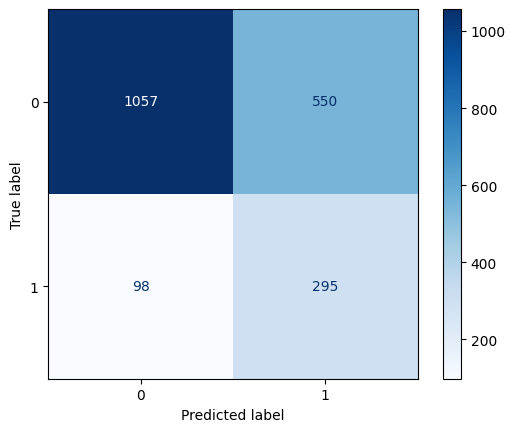

In [8]:
unique_classes = np.unique(np.concatenate([y_test, y_pred]))
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax)
ax.grid(False)
plt.show()

### **Decision Tree**

In [9]:
class_weights = {0: 1, 1: 3}
model_dt = DecisionTreeClassifier(class_weight=class_weights)
model_dt.fit(X_train_resampled, y_train_resampled)
y_pred_dt = model_dt.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.88      0.83      0.86      1607
           1       0.44      0.55      0.49       393

    accuracy                           0.78      2000
   macro avg       0.66      0.69      0.67      2000
weighted avg       0.80      0.78      0.79      2000



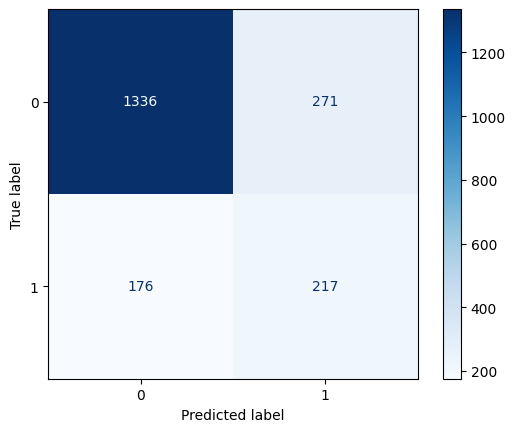

In [10]:
unique_classes = np.unique(np.concatenate([y_test, y_pred_dt]))
cm = confusion_matrix(y_test, y_pred_dt, labels=unique_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax)
ax.grid(False)
plt.show()

### **Random Forest**

In [11]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = model_rf.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1607
           1       0.58      0.59      0.58       393

    accuracy                           0.83      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.84      0.83      0.84      2000



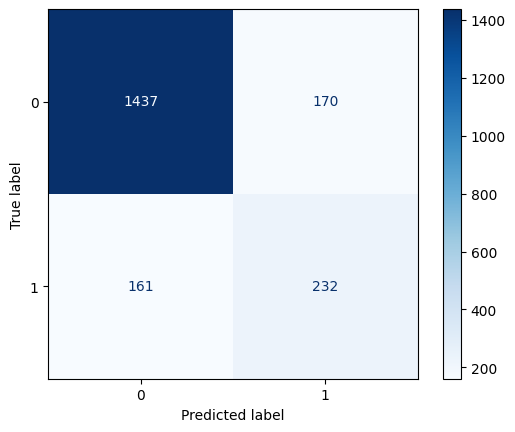

In [12]:
unique_classes = np.unique(np.concatenate([y_test, y_pred_dt]))
cm = confusion_matrix(y_test, y_pred_rf, labels=unique_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax)
ax.grid(False)
plt.show()

### **SVC Model**

In [13]:
model_svc = SVC()
model_svc.fit(X_train_resampled, y_train_resampled)
y_pred_svc = model_svc.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.94      0.69      0.80      1607
           1       0.39      0.80      0.53       393

    accuracy                           0.72      2000
   macro avg       0.66      0.75      0.66      2000
weighted avg       0.83      0.72      0.74      2000



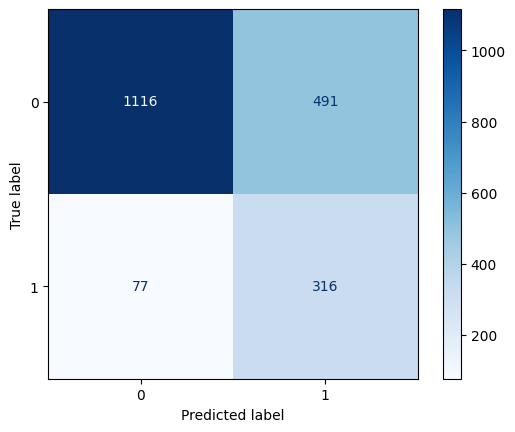

In [14]:
unique_classes = np.unique(np.concatenate([y_test, y_pred_dt]))
cm = confusion_matrix(y_test, y_pred_svc, labels=unique_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax)
ax.grid(False)
plt.show()

### **KNN Model**

In [15]:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train_resampled, y_train_resampled)
y_pred_knn = model_knn.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1607
           1       0.37      0.68      0.48       393

    accuracy                           0.71      2000
   macro avg       0.64      0.70      0.64      2000
weighted avg       0.80      0.71      0.74      2000



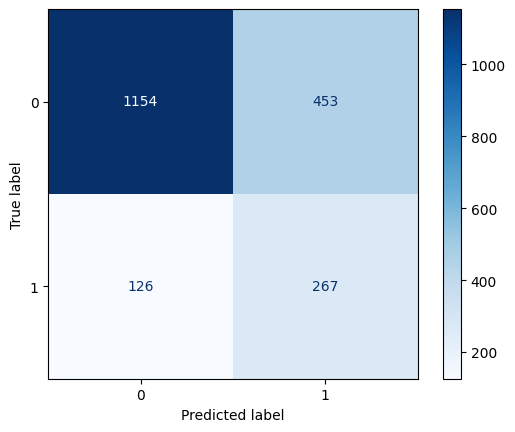

In [16]:
unique_classes = np.unique(np.concatenate([y_test, y_pred_dt]))
cm = confusion_matrix(y_test, y_pred_knn, labels=unique_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax)
ax.grid(False)
plt.show()

### **XGBoost Classifier**

In [17]:
model_xgboost = XGBClassifier()
model_xgboost.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = model_xgboost.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1607
           1       0.65      0.57      0.61       393

    accuracy                           0.85      2000
   macro avg       0.77      0.75      0.76      2000
weighted avg       0.85      0.85      0.85      2000



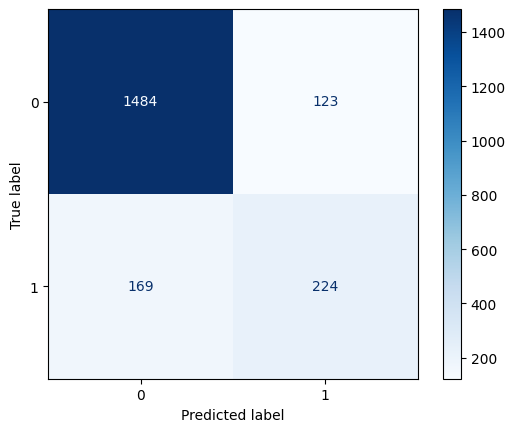

In [18]:
unique_classes = np.unique(np.concatenate([y_test, y_pred_dt]))
cm = confusion_matrix(y_test, y_pred_xgb, labels=unique_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax)
ax.grid(False)
plt.show()

### **Voting Classifier**

In [19]:
voting = VotingClassifier(estimators=[
    ('dt', model_dt),
    ('rf', model_rf),
    ('svc', model_svc),
    ('knn', model_knn),
    ('xgb', model_xgboost)
])
voting.fit(X_train_resampled, y_train_resampled)


VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(class_weight={0: 1,
                                                                   1: 3})),
                             ('rf', RandomForestClassifier()), ('svc', SVC()),
                             ('knn', KNeighborsClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))])

In [20]:
y_pred_vote = voting.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred_vote))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1607
           1       0.55      0.65      0.60       393

    accuracy                           0.83      2000
   macro avg       0.73      0.76      0.74      2000
weighted avg       0.84      0.83      0.83      2000

